# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                            
Sample_162  A0A0B4J1Y9                                                   21.121
Sample_062  Q9H8L6                                                       18.138
Sample_153  Q06033;Q06033-2                                              17.522
Sample_106  A0A087WTA1;A0A0A0MR20;E9PDN6;F5H107;Q9C0A0;Q9C0A0-2          17.218
Sample_170  A0A1W2PRS4;E9PKK2;E9PR26;Q86YT9;Q86YT9-2;Q86YT9-3;Q86YT9-4   14.124
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_151  A0A0B4J1Y8        17.152
Sample_149  Q9Y281;Q9Y281-3   12.546
Sample_184  O75083            15.424
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.731
            A0A075B6Q5                 13.197
            A0A075B6R2                 13.814
            A0A075B6S5                 12.113
            A0A087WSY4                 13.348
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.407
            Q9UI40;Q9UI40-2            12.955
            Q9UIW2                     13.356
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.060
            Q9UP79                     12.550
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.013,15.050,16.842,19.863,15.791,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.798,19.067,...,15.528,15.576,14.020,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.862,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.265,17.705,17.039,15.969,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.515,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.277,15.345,17.084,18.708,14.249,19.433,11.239,11.067
Sample_207,15.739,16.877,15.469,16.898,15.031,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.731,...,16.012,15.178,11.803,15.050,16.842,19.863,14.078,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.009,19.067,16.188,...,15.528,15.576,12.828,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.367,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.500,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.709,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.515,15.345,17.084,18.708,14.249,19.433,12.977,11.041
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 397.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.00it/s]

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.91it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

100%|██████████| 4/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.78it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.17it/s]

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:01<00:00,  2.94it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.18it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.88it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.51it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.20it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.36it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.20it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.04it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.90it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.69it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.67it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.69it/s]

100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.66it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.34it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.71it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.57it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.38it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.80it/s]

 30%|███       | 3/10 [00:00<00:01,  5.01it/s]

 40%|████      | 4/10 [00:00<00:01,  4.25it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.62it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.55it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.86it/s]

100%|██████████| 10/10 [00:03<00:00,  2.46it/s]

100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.80it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.31it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.05it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.86it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.65it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.10it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.98it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.48it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.91it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.38it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.76it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.44it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.26it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.49it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.52it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.34it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.52it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.69it/s]

100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.39it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.81it/s]

 31%|███       | 4/13 [00:01<00:03,  2.97it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.55it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.22it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.29it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.24it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.44it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.56it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.51it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.56it/s]

100%|██████████| 13/13 [00:04<00:00,  2.57it/s]

100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.59it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.53it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.24it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.10it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.16it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.19it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.31it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.25it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.21it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.30it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.49it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.67it/s]

100%|██████████| 14/14 [00:05<00:00,  2.68it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.48it/s]

 20%|██        | 3/15 [00:00<00:03,  3.84it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.52it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.36it/s]

 40%|████      | 6/15 [00:01<00:02,  3.29it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.24it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.12it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.18it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.06it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.04it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.88it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.78it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.90it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

100%|██████████| 15/15 [00:04<00:00,  3.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.018          0.788 0.321       0.122   
2             0.003 0.000      0.044 0.009          0.621 0.115       0.537   
3             0.004 0.002      0.051 0.015          0.774 0.094       0.710   
4             0.005 0.004      0.056 0.019          0.771 0.090       0.696   
5             0.008 0.007      0.092 0.027          0.809 0.079       0.772   
6             0.005 0.004      0.058 0.018          0.828 0.080       0.795   
7             0.004 0.000      0.045 0.009          0.826 0.084       0.799   
8             0.004 0.003      0.058 0.019          0.837 0.081       0.801   
9             0.006 0.005      0.069 0.029          0.831 0.076       0.799   
10            0.006 0.005      0.078 0.031          0.824 0.080       0.793   
11            0.005 0.004      0.068 0.030          0.824 0.074       0.828   
12            0.005 0.003      0.063 0.023          0.815 0.077       0.828   
13            0.004 0.002      0.050 0.014          0.812 0.075       0.832   
14            0.004 0.000      0.049 0.014          0.818 0.079       0.814   
15            0.005 0.004      0.055 0.021          0.830 0.081       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.204 0.128                  0.553 0.042        0.849   
2          0.121   0.569 0.101                  0.646 0.071        0.728   
3          0.105   0.734 0.074                  0.776 0.062        0.863   
4          0.140   0.724 0.097                  0.771 0.073        0.880   
5          0.107   0.785 0.071                  0.818 0.058        0.906   
6          0.094   0.808 0.068                  0.836 0.057        0.912   
7          0.091   0.809 0.069                  0.837 0.058        0.911   
8          0.092   0.815 0.066                  0.842 0.056        0.913   
9          0.088   0.811 0.062                  0.839 0.053        0.912   
10         0.092   0.804 0.063                  0.833 0.053        0.910   
11         0.087   0.822 0.060                  0.848 0.052        0.920   
12         0.098   0.818 0.071                  0.845 0.061        0.919   
13         0.099   0.819 0.071                  0.845 0.062        0.916   
14         0.095   0.813 0.071                  0.840 0.060        0.919   
15         0.092   0.816 0.072                  0.843 0.060        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.087        210.000 0.000  
2          0.073                  0.675 0.088        210.000 0.000  
3          0.055                  0.827 0.070        210.000 0.000  
4          0.052                  0.843 0.067        210.000 0.000  
5          0.047                  0.882 0.057        210.000 0.000  
6          0.049                  0.893 0.058        210.000 0.000  
7          0.050                  0.894 0.058        210.000 0.000  
8          0.048                  0.900 0.054        210.000 0.000  
9          0.048                  0.898 0.053        210.000 0.000  
10         0.048                  0.897 0.054        210.000 0.000  
11         0.046                  0.909 0.047        210.000 0.000  
12         0.047                  0.908 0.050        210.000 0.000  
13         0.049                  0.906 0.051        210.000 0.000  
14         0.046                  0.909 0.048        210.000 0.000  
15         0.045                  0.910 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 474.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.05it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.34it/s]

100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.32it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.63it/s]

100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.10it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.53it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.60it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.76it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.49it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.82it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.57it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.40it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.29it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.24it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.48it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.32it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.89it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.98it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.88it/s]

100%|██████████| 9/9 [00:02<00:00,  2.82it/s]

100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.77it/s]

 30%|███       | 3/10 [00:00<00:01,  3.62it/s]

 40%|████      | 4/10 [00:01<00:01,  3.16it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.86it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.81it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.31it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.07it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.98it/s]

100%|██████████| 10/10 [00:04<00:00,  1.90it/s]

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.75it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.03it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.43it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.75it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.22it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.14it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.00it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.04it/s]

100%|██████████| 11/11 [00:04<00:00,  2.05it/s]

100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.77it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.60it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.43it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.52it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.51it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.56it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.50it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.47it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.58it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.66it/s]

100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.28it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.54it/s]

 31%|███       | 4/13 [00:01<00:02,  3.15it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.98it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.79it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.75it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.76it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.74it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.83it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

100%|██████████| 13/13 [00:04<00:00,  2.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.48it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.56it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.99it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.93it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.67it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.56it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.66it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.66it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.70it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.81it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.88it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.90it/s]

100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.57it/s]

 20%|██        | 3/15 [00:00<00:03,  3.65it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.06it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.03it/s]

 40%|████      | 6/15 [00:01<00:02,  3.01it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.03it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.99it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.87it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.02it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.02it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.61it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.55it/s]

100%|██████████| 15/15 [00:05<00:00,  2.26it/s]

100%|██████████| 15/15 [00:05<00:00,  2.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.054 0.021          0.010 0.071       0.001   
2             0.005 0.004      0.063 0.024          0.771 0.120       0.627   
3             0.004 0.002      0.046 0.008          0.753 0.090       0.665   
4             0.005 0.003      0.058 0.019          0.750 0.093       0.659   
5             0.004 0.003      0.056 0.017          0.741 0.099       0.655   
6             0.004 0.002      0.053 0.020          0.736 0.099       0.666   
7             0.005 0.005      0.056 0.019          0.743 0.104       0.691   
8             0.004 0.001      0.056 0.022          0.744 0.101       0.689   
9             0.005 0.004      0.067 0.023          0.765 0.100       0.740   
10            0.005 0.004      0.055 0.023          0.773 0.096       0.749   
11            0.004 0.002      0.049 0.014          0.790 0.087       0.787   
12            0.004 0.002      0.042 0.008          0.787 0.092       0.780   
13            0.005 0.003      0.053 0.017          0.786 0.090       0.781   
14            0.005 0.004      0.062 0.023          0.781 0.089       0.784   
15            0.005 0.005      0.057 0.023          0.794 0.090       0.781   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.858   
2          0.124   0.682 0.093                  0.741 0.070        0.787   
3          0.116   0.701 0.088                  0.752 0.066        0.851   
4          0.117   0.696 0.091                  0.748 0.068        0.849   
5          0.132   0.688 0.095                  0.742 0.072        0.865   
6          0.132   0.692 0.095                  0.744 0.073        0.866   
7          0.132   0.710 0.101                  0.757 0.081        0.872   
8          0.127   0.710 0.097                  0.757 0.077        0.870   
9          0.123   0.748 0.096                  0.786 0.080        0.883   
10         0.127   0.757 0.098                  0.794 0.081        0.886   
11         0.115   0.783 0.081                  0.816 0.068        0.911   
12         0.118   0.778 0.085                  0.811 0.072        0.912   
13         0.117   0.779 0.083                  0.812 0.070        0.911   
14         0.119   0.777 0.084                  0.810 0.071        0.911   
15         0.110   0.783 0.080                  0.815 0.067        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.088        210.000 0.000  
2          0.076                  0.732 0.095        210.000 0.000  
3          0.061                  0.818 0.075        210.000 0.000  
4          0.062                  0.815 0.073        210.000 0.000  
5          0.056                  0.835 0.068        210.000 0.000  
6          0.056                  0.837 0.066        210.000 0.000  
7          0.059                  0.843 0.068        210.000 0.000  
8          0.060                  0.839 0.069        210.000 0.000  
9          0.058                  0.862 0.065        210.000 0.000  
10         0.057                  0.860 0.068        210.000 0.000  
11         0.048                  0.887 0.057        210.000 0.000  
12         0.048                  0.891 0.056        210.000 0.000  
13         0.048                  0.889 0.056        210.000 0.000  
14         0.048                  0.890 0.057        210.000 0.000  
15         0.047                  0.895 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 876.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.10it/s]

100%|██████████| 3/3 [00:00<00:00, 15.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.37it/s]

100%|██████████| 4/4 [00:00<00:00, 17.30it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.35it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.96it/s]

100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.53it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.18it/s]

100%|██████████| 6/6 [00:00<00:00, 12.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.60it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.27it/s]

100%|██████████| 7/7 [00:00<00:00, 15.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.13it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.03it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.46it/s]

100%|██████████| 8/8 [00:00<00:00, 13.74it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 26.34it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 20.19it/s]

100%|██████████| 9/9 [00:00<00:00, 19.66it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.65it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.94it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.66it/s]

100%|██████████| 10/10 [00:00<00:00, 13.65it/s]

100%|██████████| 10/10 [00:00<00:00, 15.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 30.35it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 25.10it/s]

100%|██████████| 11/11 [00:00<00:00, 20.67it/s]

100%|██████████| 11/11 [00:00<00:00, 21.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.64it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.81it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 18.51it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 19.76it/s]

100%|██████████| 12/12 [00:00<00:00, 19.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.88it/s]

 46%|████▌     | 6/13 [00:00<00:00, 22.07it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 22.67it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 21.76it/s]

100%|██████████| 13/13 [00:00<00:00, 22.19it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 27.58it/s]

 50%|█████     | 7/14 [00:00<00:00, 23.40it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 23.63it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 23.09it/s]

100%|██████████| 14/14 [00:00<00:00, 23.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 26.63it/s]

 40%|████      | 6/15 [00:00<00:00, 24.46it/s]

 60%|██████    | 9/15 [00:00<00:00, 23.49it/s]

 80%|████████  | 12/15 [00:00<00:00, 23.33it/s]

100%|██████████| 15/15 [00:00<00:00, 23.80it/s]

100%|██████████| 15/15 [00:00<00:00, 23.88it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.048 0.014          0.000 0.000       0.000   
2             0.005 0.005      0.056 0.021          0.587 0.193       0.197   
3             0.004 0.002      0.050 0.013          0.662 0.119       0.522   
4             0.003 0.001      0.043 0.010          0.662 0.115       0.562   
5             0.005 0.004      0.058 0.021          0.657 0.107       0.570   
6             0.004 0.002      0.050 0.015          0.648 0.110       0.567   
7             0.004 0.003      0.042 0.008          0.674 0.112       0.585   
8             0.004 0.002      0.041 0.010          0.673 0.113       0.577   
9             0.003 0.001      0.036 0.013          0.688 0.108       0.598   
10            0.003 0.001      0.031 0.008          0.690 0.114       0.595   
11            0.002 0.000      0.027 0.004          0.663 0.105       0.578   
12            0.002 0.000      0.027 0.004          0.669 0.096       0.585   
13            0.002 0.001      0.029 0.007          0.652 0.097       0.590   
14            0.002 0.001      0.029 0.006          0.678 0.091       0.630   
15            0.002 0.001      0.029 0.005          0.673 0.089       0.626   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.733   
2          0.085   0.281 0.101                  0.539 0.045        0.594   
3          0.114   0.576 0.099                  0.661 0.068        0.760   
4          0.119   0.600 0.099                  0.673 0.070        0.779   
5          0.119   0.604 0.098                  0.675 0.068        0.775   
6          0.120   0.598 0.101                  0.669 0.072        0.770   
7          0.117   0.620 0.096                  0.686 0.071        0.777   
8          0.116   0.614 0.092                  0.683 0.068        0.773   
9          0.114   0.633 0.091                  0.697 0.066        0.769   
10         0.124   0.631 0.097                  0.697 0.068        0.766   
11         0.129   0.609 0.095                  0.679 0.069        0.774   
12         0.128   0.617 0.097                  0.685 0.072        0.785   
13         0.114   0.614 0.088                  0.678 0.069        0.783   
14         0.111   0.648 0.086                  0.705 0.070        0.797   
15         0.110   0.644 0.085                  0.701 0.068        0.794   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.685 0.085        210.000 0.000  
2          0.069                  0.556 0.072        210.000 0.000  
3          0.074                  0.712 0.087        210.000 0.000  
4          0.074                  0.732 0.089        210.000 0.000  
5          0.072                  0.730 0.084        210.000 0.000  
6          0.071                  0.724 0.083        210.000 0.000  
7          0.068                  0.734 0.082        210.000 0.000  
8          0.068                  0.731 0.081        210.000 0.000  
9          0.072                  0.728 0.088        210.000 0.000  
10         0.069                  0.724 0.086        210.000 0.000  
11         0.065                  0.734 0.077        210.000 0.000  
12         0.064                  0.737 0.082        210.000 0.000  
13         0.065                  0.741 0.076        210.000 0.000  
14         0.065                  0.754 0.078        210.000 0.000  
15         0.067                  0.751 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,15,2
score_time,5,9,5
test_precision,8,15,10
test_recall,13,11,14
test_f1,11,11,14
test_balanced_accuracy,11,11,14
test_roc_auc,15,15,14
test_average_precision,15,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.59it/s]

 20%|██        | 3/15 [00:00<00:02,  5.20it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.78it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.41it/s]

 40%|████      | 6/15 [00:01<00:02,  4.40it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.51it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.60it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.63it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.66it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.65it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.71it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.75it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  4.71it/s]

100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

100%|██████████| 15/15 [00:03<00:00,  4.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 27.51it/s]

 50%|█████     | 7/14 [00:00<00:00, 24.01it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 22.62it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 22.58it/s]

100%|██████████| 14/14 [00:00<00:00, 23.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.98it/s]

 20%|██        | 3/15 [00:00<00:01,  7.37it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.42it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.02it/s]

 40%|████      | 6/15 [00:00<00:01,  5.81it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.72it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.67it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.66it/s]

 67%|██████▋   | 10/15 [00:01<00:01,  4.70it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  5.01it/s]

 80%|████████  | 12/15 [00:02<00:00,  5.19it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.15it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.30it/s]

100%|██████████| 15/15 [00:02<00:00,  5.35it/s]

100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


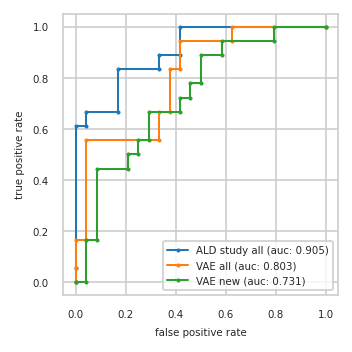

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.611   0.000 0.167   0.042 0.167
3          0.042 0.611   0.042 0.167   0.083 0.167
4          0.042 0.667   0.042 0.556   0.083 0.444
5          0.167 0.667   0.333 0.556   0.208 0.444
6          0.167 0.833   0.333 0.667   0.208 0.500
7          0.333 0.833   0.375 0.667   0.250 0.500
8          0.333 0.889   0.375 0.833   0.250 0.556
9          0.417 0.889   0.417 0.833   0.292 0.556
10         0.417 1.000   0.417 0.944   0.292 0.667
11         1.000 1.000   0.625 0.944   0.417 0.667
12           NaN   NaN   0.625 1.000   0.417 0.722
13           NaN   NaN   1.000 1.000   0.458 0.722
14           NaN   NaN     NaN   NaN   0.458 0.778
15           NaN   NaN     NaN   NaN   0.500 0.778
16           NaN   NaN     NaN   NaN   0.500 0.889
17           NaN   NaN     NaN   NaN   0.583 0.889
18           NaN   NaN     NaN   NaN   0.583 0.944
19           NaN   NaN     NaN   NaN   0.792 0.944
20           NaN   NaN     NaN   NaN   0.792 1.000
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NBI6,H0YMB1;Q96TC7;Q96TC7-2,Q8WYK1
2,P60709;P63261,P08670,P51688
3,P04075,Q9Y2T3;Q9Y2T3-3,P31321
4,P14174,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P61981,P61981,Q96GD0
6,P00338;P00338-3,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,Q9NUQ9
8,P08294,P63104,J3KSJ8;Q9UD71;Q9UD71-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


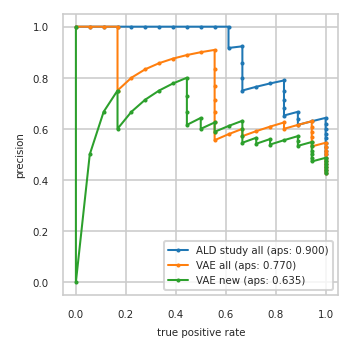

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.571 0.667
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.789 0.833     0.579 0.611     0.632 0.667
24         0.778 0.778     0.556 0.556     0.611 0.611
25         0.765 0.722     0.588 0.556     0.588 0.556
26         0.750 0.667     0.625 0.556     0.625 0.556
27         0.800 0.667     0.667 0.556     0.600 0.500
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.727 0.444
32         1.000 0.556     0.900 0.500     0.800 0.444
33         1.000 0.500     0.889 0.444     0.778 0.389
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


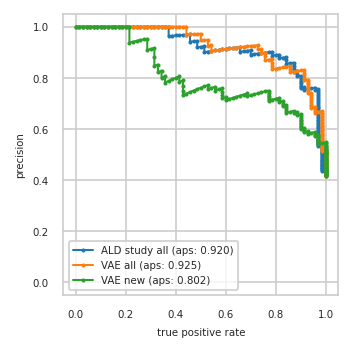

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


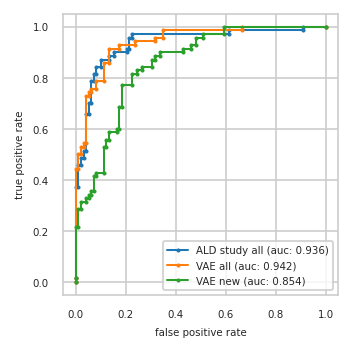

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}